# percent-allocate

Maintain a percent allocation of a security in account  
(1) If bull regime, set target share of 70%.  Allow range of 68% to 72%.  Check daily.  
(2) If bear regime, close out position

In [1]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
from talib.abstract import *

import pinkfish as pf

# Format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# Set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
#symbol = '^GSPC'
symbol = 'SPY'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
capital = 10000
#start = datetime.datetime(1900, 1, 1)
start = datetime.datetime(*pf.SP500_BEGIN)
end = datetime.datetime.now()

Define target_percent and band

In [4]:
options = {
    'use_adj' : True,
    'use_cache' : True,
    'target_percent' : 70,
    'band' : 1
}

Define Strategy Class 

In [5]:
class Strategy:

    def __init__(self, symbol, capital, start, end, options):

        self.symbol = symbol
        self.capital = capital
        self.start = start
        self.end = end
        self.options = options
        
        self.ts = None
        self.rlog = None
        self.tlog = None
        self.dbal = None
        self.stats = None

    def _algo(self):
        pf.TradeLog.cash = self.capital

        for i, row in enumerate(self.ts.itertuples()):

            date = row.Index.to_pydatetime()
            high = row.high; low = row.low; close = row.close; 
            end_flag = pf.is_last_row(self.ts, i)
            
            share_percent = self.tlog.share_percent(close)
            target_percent = self.options['target_percent'] 
            upper_band = target_percent + self.options['band']
            lower_band = target_percent - self.options['band']
            
            # Close Out Logic
            # First we check if an existing position in symbol should be sold
            #  - sell if regime < 0 or end of data

            if (self.tlog.shares > 0
                and (row.regime < 0 or end_flag)):
                # close position
                self.tlog.adjust_percent(date, close, 0)

            # Adjust Shares Logic
            #  - Adjust Shares if regime > 0
            #            and share percent outside of target_percent band
            #            and (use_regime_filter and regime > 0)
            
            else:
                if (row.regime > 0
                    and (share_percent < lower_band or share_percent > upper_band)):
                    # adjust shares to target_percent
                    self.tlog.adjust_percent(date, close, target_percent)   

            # record daily balance
            self.dbal.append(date, high, low, close)

    def run(self):
        
        # Fetch and select timeseries
        self.ts = pf.fetch_timeseries(self.symbol, use_cache=self.options['use_cache'])
        self.ts = pf.select_tradeperiod(self.ts, self.start, self.end, use_adj=self.options['use_adj'])

        # Add technical indicator: 200 sma regime filter plus 3% band
        self.ts['regime'] = \
            pf.CROSSOVER(self.ts, timeperiod_fast=1, timeperiod_slow=200, band=3.0)
        
        # Finalize timeseries
        self.ts, self.start = pf.finalize_timeseries(self.ts, self.start)

        self.tlog = pf.TradeLog(self.symbol)
        self.dbal = pf.DailyBal()

        self._algo()
        self._get_logs()
        self._get_stats()
        
    def _get_logs(self):
        self.rlog = self.tlog.get_log_raw()
        self.tlog = self.tlog.get_log()
        self.dbal = self.dbal.get_log(self.tlog)

    def _get_stats(self):
        self.stats = pf.stats(self.ts, self.tlog, self.dbal, self.capital)

Run Strategy

In [6]:
s = Strategy(symbol, capital, start, end, options)
s.run()

View logs

In [7]:
s.rlog.tail()

,date,seq_num,price,shares,entry_exit,direction,symbol
146,2020-11-05,146,347.61,2,exit,LONG,SPY
147,2020-12-04,147,367.08,2,exit,LONG,SPY
148,2021-02-08,148,389.24,2,exit,LONG,SPY
149,2021-03-04,149,375.47,1,entry,LONG,SPY
150,2021-04-01,150,400.61,108,exit,LONG,SPY


In [8]:
s.tlog.tail()

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total,direction,symbol
133,2020-06-02,303.22,2021-04-01,400.61,97.39,10031.44,103,50633.91,LONG,SPY
134,2020-09-08,329.39,2021-04-01,400.61,71.22,71.22,1,50705.13,LONG,SPY
135,2020-09-23,320.22,2021-04-01,400.61,80.39,80.39,1,50785.52,LONG,SPY
136,2020-10-28,324.21,2021-04-01,400.61,76.40,152.80,2,50938.31,LONG,SPY
137,2021-03-04,375.47,2021-04-01,400.61,25.14,25.14,1,50963.45,LONG,SPY


In [9]:
s.dbal.tail()

,high,low,close,shares,cash,leverage,state
date,,,,,,,
2021-03-26,60515.10,59854.14,60468.66,108,17702.82,1.00,-
2021-03-29,60551.82,60126.30,60447.06,108,17702.82,1.00,-
2021-03-30,60411.42,60148.98,60333.66,108,17702.82,1.00,-
2021-03-31,60686.82,60396.30,60506.46,108,17702.82,1.00,-
2021-04-01,60963.45,60963.45,60963.45,0,60963.45,1.00,X


Run Benchmark

In [10]:
benchmark = pf.Benchmark(symbol, s.capital, s.start, s.end)
benchmark.run()

Plot Equity Curves: Strategy vs Benchmark

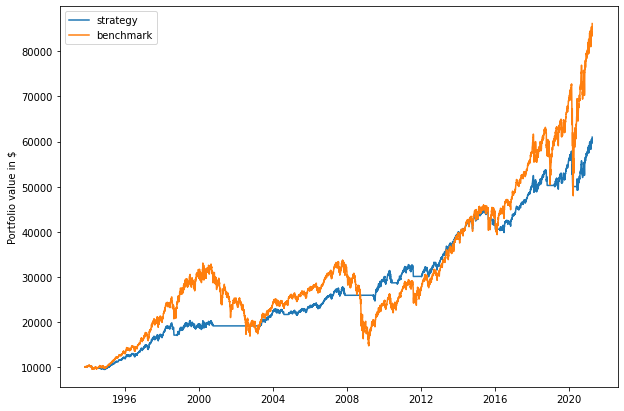

In [11]:
pf.plot_equity_curve(s.dbal, benchmark=benchmark.dbal)

Plot Trades

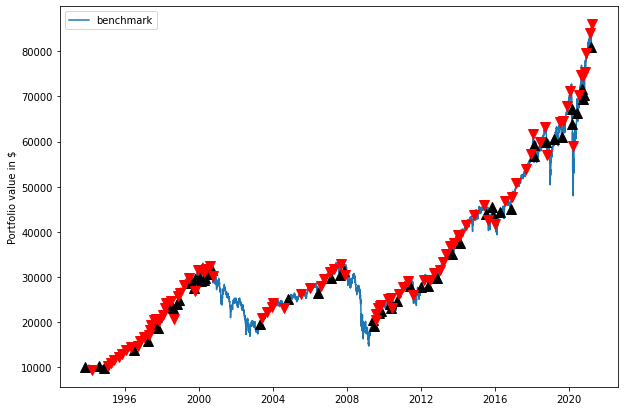

In [12]:
pf.plot_trades(s.dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,6.82,8.18
max_closed_out_drawdown,-15.01,-56.42
annualized_return_over_max_drawdown,0.45,0.14
best_month,10.65,23.06
worst_month,-13.55,-31.38
sharpe_ratio,0.79,0.51
sortino_ratio,0.88,0.65
monthly_std,2.21,4.52
annual_std,8.12,16.59


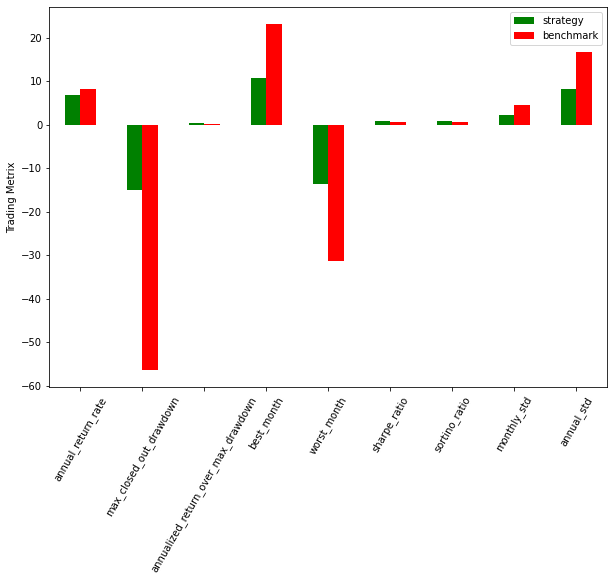

In [13]:
df = pf.plot_bar_graph(s.stats, benchmark.stats)
df